# MatLearn for Users

Import the necessary libraries to run this notebook by running the cell below

In [1]:
import os
import MatLearn_User_functions as mlf
from importlib import reload
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from pymatgen import MPRester
from statistics import mean
import tqdm
import itertools
import math

# Change to your current working directory below
os.chdir("C:/Users/gpeters2/Desktop/MatLearn/User")
print('Current working directory path:',os.getcwd())

Current working directory path: C:\Users\gpeters2\Desktop\MatLearn\User


## Generate Dataset

This section only needs to be run once to generate the MP_descriptors.xlsx file. Once you have that in your folder, you can skip this section and load the dataset in one of the steps below.

In [2]:
# Pull data from the Materials Project for all compounds with calculated formation energies
with MPRester("JpwfWeIx2s6B1nil") as m: # Make sure API key matches personal key given by MP
    data = m.query(criteria={"formation_energy_per_atom":{"$exists":True}},
                   properties=['material_id',
                               "pretty_formula",
                               'formation_energy_per_atom',
                               'e_above_hull',
                               'icsd_ids'])

# Generate a dataframe object    
data_df = pd.DataFrame(data)
data_df.rename(mapper = {'pretty_formula':'Composition','formation_energy_per_atom':'Hf'},inplace=True,axis=1)

# Save raw dataframe as excel spreadsheet for future use
data_df.to_excel('MP_data_raw.xlsx',index=False)

In [5]:
# Alternatively, load a previously saved dataset
data_df = pd.read_excel('MP_data_raw.xlsx')

## Generate Features

Must have a 'data_df' dataframe object loaded from the section above. Once you have written the output_file, this section can be skipped and you can load both 'data_df' and 'feature_df' in the first cell of the training section below.

In [7]:
# Clean the raw dataset to remove duplicates, unsupported elements, and null entries
data_df = mlf.clean_data(data_df,
                         label_col='Composition',
                         target_cols = ['Hf'],
                         remove_dupes_keep = 'low',
                         target_range = (-10,1), # Hf values significantly above 0 are unstable and hard to model
                         remove_non_icsd = ['icsd_ids','[]'],
                         output_file='MP_data.xlsx')

Removed 0/126335 null or infinite Hf entries
Removed 2569/126335 out of range entries
Removed 36198/123766 duplicate entries, kept lowest value
Removed 1648/87568 bad element entries
Removed 46276/85920 non-ICSD entries
Cleaned compounds remaining: 39644
Writing output to MP_data.xlsx


In [8]:
# Generate features for the data
feature_df = mlf.write_features(data_df,label_col = 'Composition',output_file = 'MP_descriptors.xlsx')

100%|███████████████████████████████████████████████████████████████████████████| 39644/39644 [03:35<00:00, 184.16it/s]


Data Shape: (39644, 225)
Writing output to MP_descriptors.xlsx


## Random Forest Model Training

The section below is used to create your own machine learning models. Created models will be stored in memory as the 'model_list' variable, and can be saved for future use as '.joblib' files

#### Tune model parameters and visualize the fit

In [3]:
# import the cleaned Materials Project dataset and descriptor set
# not needed if these variables were already stored in memory through the cells above
data_df = pd.read_excel('MP_data.xlsx')
feature_df = pd.read_excel('MP_descriptors.xlsx')

In [13]:
# number of independent models to train (independent holdout sets)
n_models = 3

# name of the column in data_df that you want to train on (as a string, i.e. in ' ')
target_col = 'Hf'

# range of max features to try. either 'range(X,Y,Z)' X min, Y max, Z step -- or [X,Y,Z] will try X, Y, and Z
mf_range = [30,35,40]

# number of individual trees in the forest
n_est = 50

# fraction of training data to use in the training set (rest to holdout set)
split_fraction = 0.8

Training data size: 31715
Test data size: 7929
Cross validation r2_score 0.9682
Cross validation mean_absolute_error 0.1058
Cross validation mean_squared_error 0.0323


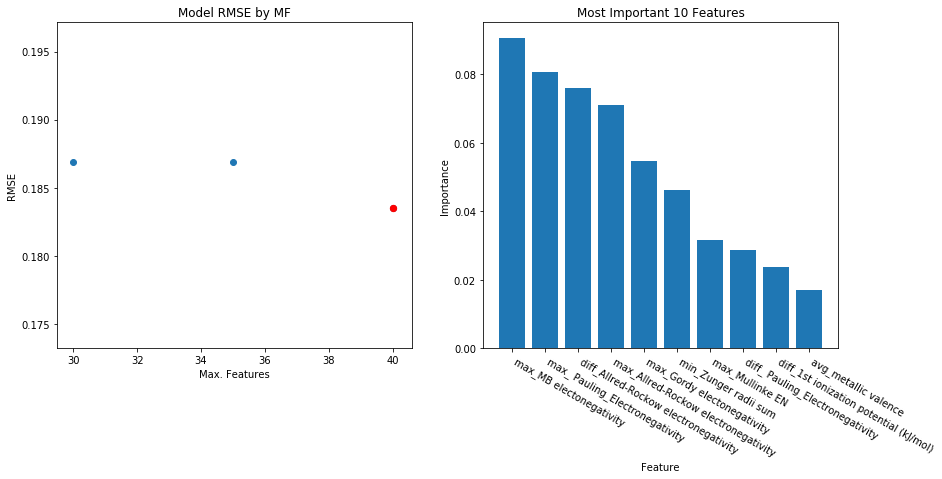

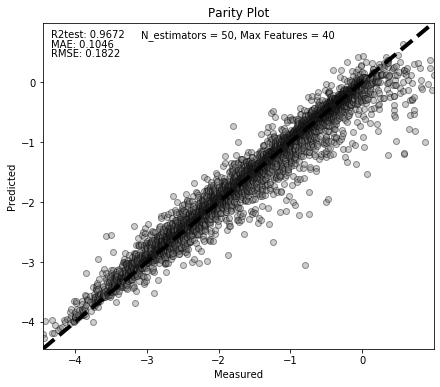

Training data size: 31715
Test data size: 7929
Cross validation r2_score 0.9676
Cross validation mean_absolute_error 0.1063
Cross validation mean_squared_error 0.0331


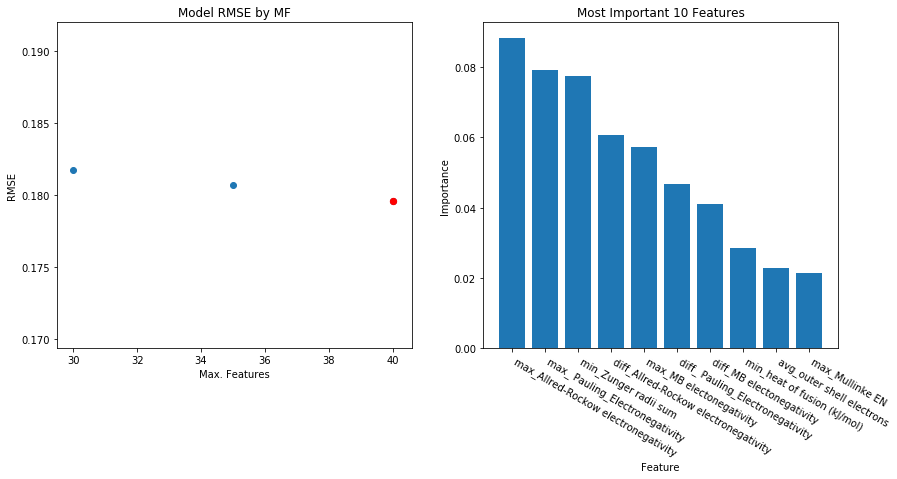

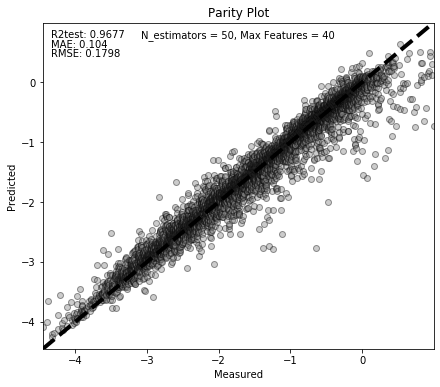

Training data size: 31715
Test data size: 7929
Cross validation r2_score 0.9673
Cross validation mean_absolute_error 0.1068
Cross validation mean_squared_error 0.0333


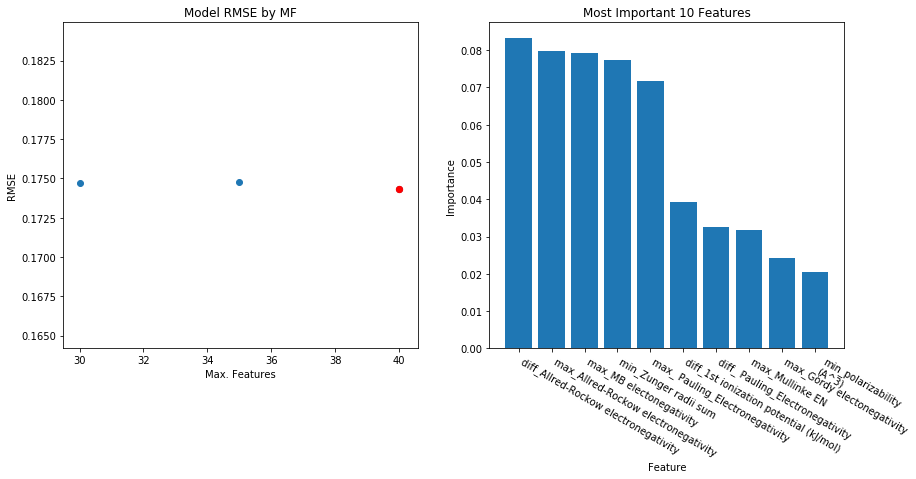

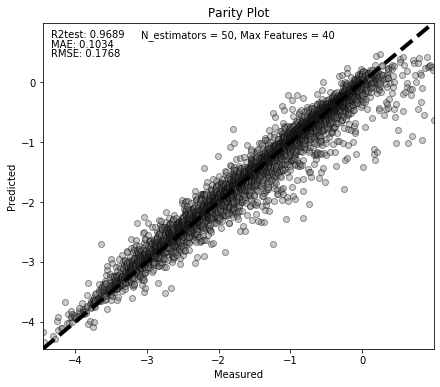

In [14]:
# train models by running this cell. will generate the 'model_list' object
model_list = []
for i in range(n_models):
    X_train,y_train,X_test,y_test,model = mlf.train_rf_model(feature_df=feature_df,
                                                             target_df=data_df[target_col],
                                                             mf_range=mf_range,
                                                             n_est=n_est,
                                                             split_fraction = split_fraction,
                                                             rand_state=i)
    mlf.test_rf_model(X_train,y_train,X_test,y_test,model)
    model_list.append(model)

#### Compare Models (optional)

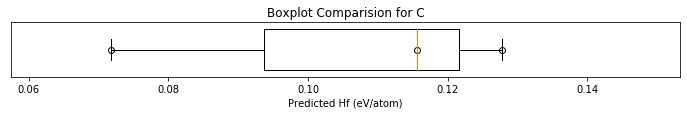

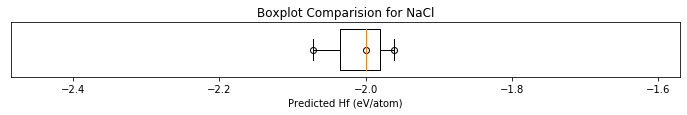

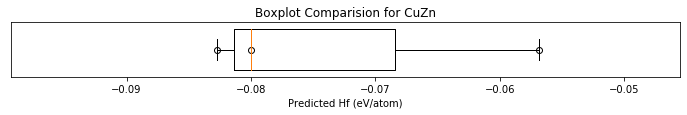

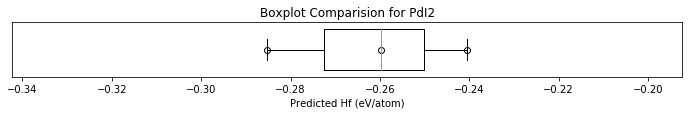

In [16]:
# create a boxplot comparing predictions across all models in model list for a specified list of compounds (test_compounds)
# this cell is not needed, but can be used to estimate the consistency of the models
test_compounds = ['C','NaCl','CuZn','PdI2']

mlf.boxplot_compare_pred(model_list,test_compounds)

#### Save Models (optional)

In [17]:
# save models as .joblib files for future use
from joblib import dump
for i in range(len(model_list)):
    dump(model_list[i],f'model{i}.joblib')

## Predictions and Plotting

Need a feature_df, data_df, and model_list to make predictions. If these have already been created locally through the cells above, skip to 'Generate Predictions'. Otherwise, import the datasets and models with the code below.

In [151]:
# to load feature_df and data_df
feature_df = pd.read_excel('MP_descriptors.xlsx',index=None)
data_df = pd.read_excel('MP_data.xlsx',index=None)

In [152]:
# import an array of pre-trained models to generate an average prediction
# number of models to load
n_models = 3

# to load a model list
from joblib import load
model_list = []
for i in range(n_models):
    model_list.append(load(f'model{i}.joblib'))

In [ ]:
# to import a single model
model_list = [load('Matlearn-MPRF-model0.joblib')]

#### Generate Predictions

In [19]:
# uncomment the 'export_image_name' line to save the output as a vector image
# if write_data = True, will save a spreadsheet of the output predictions
# edit step_size, e_above_max (in meV above the hull), and point_scale to your preferences

data_pd = mlf.predict_pd(step_size = 5,
                         model_list=model_list,
                         write_data = False
                    )

mlf.plot_pd(data_pd,data_df,
            e_above_max=50,
            point_scale = 400,
           # export_image_name='AlEuSb_pd.svg'
           )

Enter element (blank if done): Nd
Enter element (blank if done): Au
Enter element (blank if done): Ge
Enter element (blank if done): 
Generating composition grid and features...


100%|███████████████████████████████████████████████████████████████████████████████| 231/231 [00:01<00:00, 211.79it/s]


Data Shape: (231, 225)
Generating predictions...


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.40it/s]
